In [31]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
import shap 
import matplotlib 
import re 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
import optuna 
from sklearn import preprocessing,metrics
from sklearn.model_selection import  StratifiedKFold, train_test_split,cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn import tree 
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)

In [3]:
def metric_calculation(y,y_pred):
    tp = np.count_nonzero((y_pred == y) & (y == 1))
    fn = np.count_nonzero((y_pred != y) & (y == 1))
    tn = np.count_nonzero((y_pred == y) & (y == 0))
    fp = np.count_nonzero((y_pred != y) & (y == 0))
    # sen = tp / (tp + fn) ## metrics.recall_score
    spc = tn / (tn + fp)
    # ppv = tp / (tp + fp) ## metrics.precision_score 
    npv = tn / (fn + tn) 
    return spc,npv


## Import data and split training set and testing set

In [4]:
data = pd.read_excel('../../HTdata/HT_table_20240227_clean_final.xlsx', sheet_name='All_clean')

data = data.rename(columns={'NIHSS':'NIHSS score at admission',
                         'DM':'Diabetes mellitus',
                         'TIME3': 'Time from onset to MRI',
                         'ADC<620':'$\\mathregular{ADC} < 620 × \\mathregular{10}^{-6} \\mathregular{mm}^2/\\mathregular{s}$',
                         'Tmax>4 Volume': 'Tmax > 4 s',
                         'Tmax>6 Volume': 'Tmax > 6 s',
                         'Tmax>8 Volume': 'Tmax > 8 s',
                         'Tmax>10 Volume': 'Tmax > 10 s',
                         'PWI-DWI Mismatch':'PWI-DWI mismatch',
                         'VTmax>10s/VTmax>6s':'HIR'})


features = ['Age', 'Gender', 'NIHSS score at admission', 'Diabetes mellitus', 'Hypertension', 'Atrial fibrillation', 
            'Time from onset to MRI',  
            '$\\mathregular{ADC} < 620 × \\mathregular{10}^{-6} \\mathregular{mm}^2/\\mathregular{s}$', 
            'Tmax > 4 s', 'Tmax > 6 s', 'Tmax > 8 s', 'Tmax > 10 s', 
            'PWI-DWI mismatch', 'HIR']

X_ = data[features]
## convert mismatch < 0 -> = 0:
X_['PWI-DWI mismatch'][X_['PWI-DWI mismatch'] < 0] = 0 

y = data['Group']
X = X_.copy()
le = LabelEncoder()
X[X.columns[1]] = le.fit_transform(X_.loc[:, 'Gender'])


print(X.shape)

(379, 14)


In [39]:
features

['Age',
 'Gender',
 'NIHSS score at admission',
 'Diabetes mellitus',
 'Hypertension',
 'Atrial fibrillation',
 'Time from onset to MRI',
 '$\\mathregular{ADC} < 620 × \\mathregular{10}^{-6} \\mathregular{mm}^2/\\mathregular{s}$',
 'Tmax > 4 s',
 'Tmax > 6 s',
 'Tmax > 8 s',
 'Tmax > 10 s',
 'PWI-DWI mismatch',
 'HIR']

In [6]:
random_seed =  628 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=random_seed)
scalar = preprocessing.StandardScaler().fit(X_train)
X_train_sc = scalar.transform(X_train)
X_test_sc = scalar.transform(X_test)
print(X_train.shape)
print(X_test.shape)

(265, 14)
(114, 14)


## Model hyper-parameter tuning

In [8]:
import pandas as pd
import numpy as np
import time
import pathlib
from sklearn.ensemble import GradientBoostingClassifier

### Modules

In [10]:
class BinaryObjective(object):
    def __init__(self, X, y,model_name,scoring='roc_auc'):
        self.X = X
        self.y = y
        self.model_name = model_name 
        self.scoring = scoring
        
    def __call__(self, trial):
        if self.model_name == 'LR':
            params = {
            'penalty': trial.suggest_categorical('penalty', ['l1']),
            'C': trial.suggest_float('C', 0.01,0.05),
            'max_iter': trial.suggest_int('max_iter', 1000,2000),
            'solver': trial.suggest_categorical('solver', ['liblinear'])
            }
            clf = linear_model.LogisticRegression(**params)
        
        elif self.model_name == 'SVM':
            params = {
                'C': trial.suggest_float('C', 0.1, 2),
                'kernel': trial.suggest_categorical('kernel', ['linear','poly','rbf','sigmoid']), 
                'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
                }
            clf = SVC(**params)
            
        elif self.model_name == 'DT':
            params = {
                'max_depth': trial.suggest_int('max_depth', 2, 50),
                'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
                'ccp_alpha':trial.suggest_float('ccp_alpha',0,1)
            }
            clf = tree.DecisionTreeClassifier(**params,class_weight = {0:1,1:2})
        
        elif self.model_name == 'XGBoost':
            params = {
                "max_depth": trial.suggest_int("max_depth", 2, 10),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 2.0),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 2.0),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
                'n_estimators':trial.suggest_int('n_estimators', 10, 100, 10),
            } 
            clf = xgb.XGBClassifier(**params)
        
        elif self.model_name == 'LightGBM':
            params = {
                "num_leaves": trial.suggest_int("num_leaves", 8, 32),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 2.0),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 2.0),
                'n_estimators':trial.suggest_int('n_estimators', 10, 100, 10),
                'verbose':-1
            }
            clf = lgb.LGBMClassifier(**params)
            
        elif self.model_name == 'RF':
            params = {
                "max_depth": trial.suggest_int('max_depth', 2, 10),
                "n_estimators": trial.suggest_int("n_estimators", 10, 100, 10),
                'criterion': trial.suggest_categorical('criterion', ['gini']),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 4),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 3),
            }
            clf = RandomForestClassifier(**params, n_jobs=-1,random_state=123)
        elif self.model_name == 'Cat':
            params = {
                    "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
                    "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
                    "depth": trial.suggest_int("depth", 1, 10),
                    "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                    "used_ram_limit": "3gb",
            }
        
            clf = CatBoostClassifier(**params)
        
        else:
            return 'Wrong model name'
    
        cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
        auc_scores = cross_val_score(clf, self.X, self.y, cv=cv,scoring=self.scoring)
        return auc_scores.mean()
    
    
# define model
def clf_binary(X_train, y_train,model_name = 'LR',n_trials=100,scoring='roc_auc'):
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize",
                                sampler=sampler,
                                study_name='model_eval',
                                )
    study.optimize(BinaryObjective(X_train, y_train,model_name,scoring=scoring), n_trials=n_trials)

    # Train and evaluate the model with the best hyperparameters 
    best_params = study.best_trial.params
    if model_name == 'LR':
        model = linear_model.LogisticRegression(**best_params)
    elif model_name == 'SVM':
        model = SVC(**best_params)
    elif model_name == 'DT':
        model = tree.DecisionTreeClassifier(**best_params)
    elif model_name == 'XGBoost':
        model = xgb.XGBClassifier(**best_params)
    elif model_name == 'LightGBM':
        model = lgb.LGBMClassifier(**best_params)
    elif model_name == 'RF':
        model = RandomForestClassifier(**best_params, n_jobs=-1)
    elif model_name == 'Cat':
        model = CatBoostClassifier(**best_params)
    else:
        return 'Wrong model name'
    
    model.fit(X_train, y_train)   
    
    return model

In [11]:
def train(X_train,X_train_sc,y_train,model_name='LR',scoring='roc_auc'):
    optuna.logging.set_verbosity(optuna.logging.WARNING)  # Do not print the log
    if model_name == 'DT' or model_name == 'RF':
        model = clf_binary(X_train, y_train, model_name,scoring=scoring)    
    else:
        model = clf_binary(X_train_sc, y_train,model_name,scoring=scoring)
    return model

In [12]:
def run(X_train,X_train_sc,y_train,X_test,X_test_sc,y_test,best_model,model_name = 'LR',state='TRAIN',select_flag=False):
    
    if select_flag:
        print(select_flag)
    
    else:    
        if state == 'TRAIN':
            test_y = y_train
            if model_name == 'DT' or model_name == 'RF':
                test_data = X_train
            else:
                test_data = X_train_sc
        elif state == 'TEST':     
            test_y = y_test
            if model_name == 'DT' or model_name == 'RF':
                test_data = X_test
            else:
                test_data = X_test_sc
    
    if model_name == 'SVM':
        y_pred_proba = 1/ (1+np.exp(-best_model.decision_function(test_data))) 
    else:
        y_pred_proba = best_model.predict_proba(test_data)[:, 1]  
    
    y_pred = best_model.predict(test_data)
    auc = roc_auc_score(test_y, y_pred_proba)
    f1 = f1_score(test_y, y_pred)
    acc = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred)
    recall = recall_score(test_y, y_pred)
    spc,npv = metric_calculation(test_y,y_pred)
    
    return ((y_pred_proba,y_pred),(auc,acc,f1,recall,spc,precision,npv))

In [13]:
def main(X_train,X_train_sc,y_train,X_test,X_test_sc,y_test,model_name=None,scoring='roc_auc'):
    print('MODEL: %s'%model_name)
    best_model = train(X_train,X_train_sc,y_train,model_name,scoring)
    train_result = run(X_train,X_train_sc,y_train,
                       X_test,X_test_sc,y_test,
                       best_model,model_name = model_name,state='TRAIN')
    test_result = run(X_train,X_train_sc,y_train,
                      X_test,X_test_sc,y_test,
                      best_model,model_name = model_name,state='TEST')
    df_result = pd.DataFrame({'ACC':[train_result[1][1],test_result[1][1]],
                              'AUC':[train_result[1][0],test_result[1][0]],
                              'F1': [train_result[1][2],test_result[1][2]],
                              'SEN':[train_result[1][3],test_result[1][3]],
                              'SPC':[train_result[1][4],test_result[1][4]],
                              'PPV':[train_result[1][5],test_result[1][5]],
                              'NPV':[train_result[1][6],test_result[1][6]]})
    df_result.index = ['TRAIN','TEST']
    
    return best_model,train_result,test_result,df_result.round(4)

### Logistic Regression

In [14]:
best_model_lr,train_result_lr,test_result_lr,df_result_lr = main(X_train,X_train_sc,y_train,
                                                                 X_test,X_test_sc,y_test,
                                                                 model_name='LR',
                                                                 scoring='accuracy')
df_result_lr

MODEL: LR


,ACC,AUC,F1,SEN,SPC,PPV,NPV
TRAIN,0.8113,0.8908,0.7253,0.7174,0.8613,0.7333,0.8514
TEST,0.8421,0.9070,0.7857,0.8462,0.8400,0.7333,0.9130


In [15]:
best_model_lr.intercept_

array([-0.25805565])

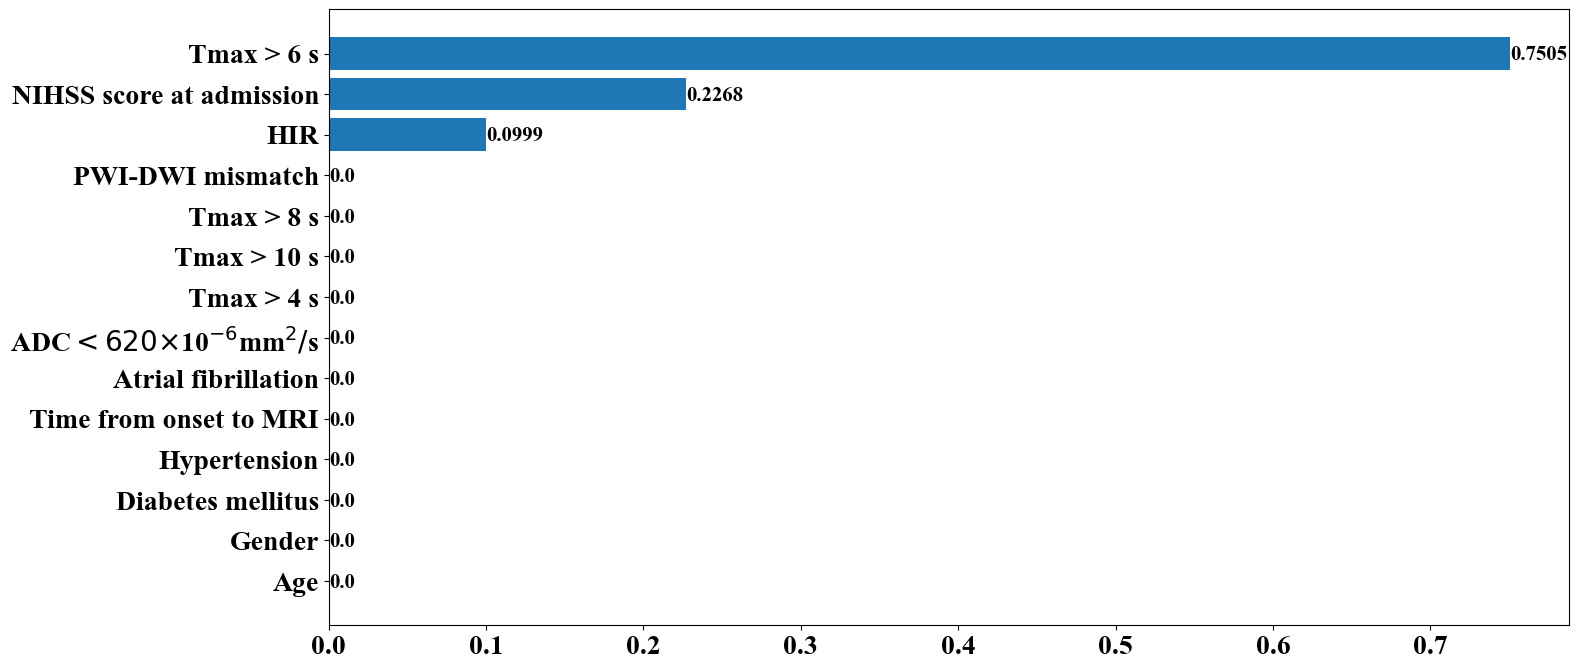

In [16]:
import_df = pd.DataFrame({'Feature':features,'Importance':best_model_lr.coef_[0]})
import_df = import_df.sort_values(ascending=True,by='Importance').round(4)
x = import_df['Feature'].tolist()
y = import_df['Importance']
plt.figure(figsize=(16,8))
plt.rcParams['font.family'] = ['Times New Roman']
plt.barh(x, y)
plt.yticks(fontsize=16)
plt.xticks(fontproperties = 'Times New Roman',fontsize=20,fontweight = "bold")
plt.yticks(fontproperties = 'Times New Roman',fontsize=20,fontweight = "bold")

for index, value in enumerate(y):
    plt.text(value+0.0003, index-0.15,round(value,4),fontsize=15,fontweight='bold')
plt.savefig('./figures/logistic_regression_feature_importance.jpg',dpi=300,bbox_inches='tight') #,pad_inches=0.0)

##### Visualization

In [48]:
from mpl_toolkits.mplot3d import Axes3D,proj3d
from matplotlib.patches import Circle, PathPatch
import mpl_toolkits.mplot3d.art3d as art3d
import plotly.express as px

In [61]:
def group(feature_ls,flag = True):
    y_pred = best_model_lr.predict(X_test_sc)
    if flag:
        # ht_feature = feature_ls[y_test[(y_test == 1)].index]  
        # noht_feature = feature_ls[y_test[(y_test == 0)].index]  
        ht_feature = feature_ls[y_test[(y_test == 1) & (y_test == y_pred)].index]  
        noht_feature = feature_ls[y_test[(y_test == 0) & (y_test == y_pred)].index] #  
        misclassify_feature = feature_ls[y_test[y_test != y_pred].index]
    else:
        # ht_feature = feature_ls[(y_test == 1)]
        # noht_feature = feature_ls[(y_test == 0)]
        ht_feature = feature_ls[(y_test == 1) & (y_test == y_pred)]
        noht_feature = feature_ls[(y_test == 0) & (y_test == y_pred)]
        misclassify_feature = feature_ls[y_test != y_pred]
         
    return (ht_feature,noht_feature,misclassify_feature)

In [82]:
def plot_feature(ls_idx,fig,idx):
    fl = ['Tmax > 6 s','HIR','NIHSS score at admission','Risk of HT']  
    
    ticks_seq = [fl[ls_idx[0]],fl[ls_idx[1]],fl[ls_idx[2]]]
    # risk = (y_pred_proba-0.5)/np.std(y_pred_proba)
    risk = best_model_lr.predict_proba(X_test_sc)[:,1]
    
    x = X_test[ticks_seq[0]]
    x_val = group(x)
    y = X_test[ticks_seq[1]]
    y_val = group(y)
    if ticks_seq[-1] == 'Risk of HT':
        z = risk 
        z_val = group(z,False)
    else:
        z = X_test[ticks_seq[-1]]
        z_val = group(z)
    
    
    ax = fig.add_subplot(idx, projection='3d')

    
 
    ## scatter plot
    if ticks_seq[-1] == 'Risk of HT':
        ax.scatter(x_val[0], y_val[0], z_val[0], c = 'red', label='HT',s=85)
        ax.scatter(x_val[1], y_val[1], z_val[1], c = 'blue', label = 'non-HT',s=85)
        ax.scatter(x_val[2], y_val[2], z_val[2], c = 'green', label = 'misclassify',s=85)
        # plt.title('Risk of %s and %s'%(ticks_seq[0],ticks_seq[1]),fontsize=35)
    else:
        risk_plot = 100 * (risk - np.min(risk)) / (np.max(risk) - np.min(risk))
        risk_plot_val = group(risk_plot,False)
        ax.scatter(x_val[0], y_val[0], z_val[0], c = 'red', label='HT',s = 85) #risk_plot_val[0]*2)
        ax.scatter(x_val[1], y_val[1], z_val[1], c = 'blue', label = 'non-HT',s = 85) #risk_plot_val[1]*2)
        ax.scatter(x_val[2], y_val[2], z_val[2], c = 'green', label = 'misclassify',s = 85) #risk_plot_val[2])
        # plt.title('Risk of %s, %s and %s'%(ticks_seq[0],ticks_seq[1],ticks_seq[2]),fontsize=45)
        
    # # ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel('HIR',fontsize=12) #,fontsize=25) #,labelpad=20)
    ax.set_ylabel('Tmax > 6 s',fontsize=12) #,fontsize=25) #,labelpad=20)
    ax.zaxis.set_rotate_label(False)  # disable automatic rotation 
    ax.set_zlabel('NIHSS score at admission',fontsize=12,rotation=90) #,fontsize=25) #,labelpad=40,rotation=0)
    
    
    
    # fig.tight_layout()
    # fig.subplots_adjust(left=-0.11)  # plot outside the normal area

    f = lambda x,y,z: proj3d.proj_transform(x,y,z, ax.get_proj())[:2]
 
    plt.legend(bbox_to_anchor=(0.85,0.7), 
                bbox_transform=fig.transFigure,
                prop={'size': 12})
     
    ax.set_xlim(1,0)
    ax.set_ylim(300,0)
    ax.set_zlim(0,45)
    ax.view_init(5, 25)
    

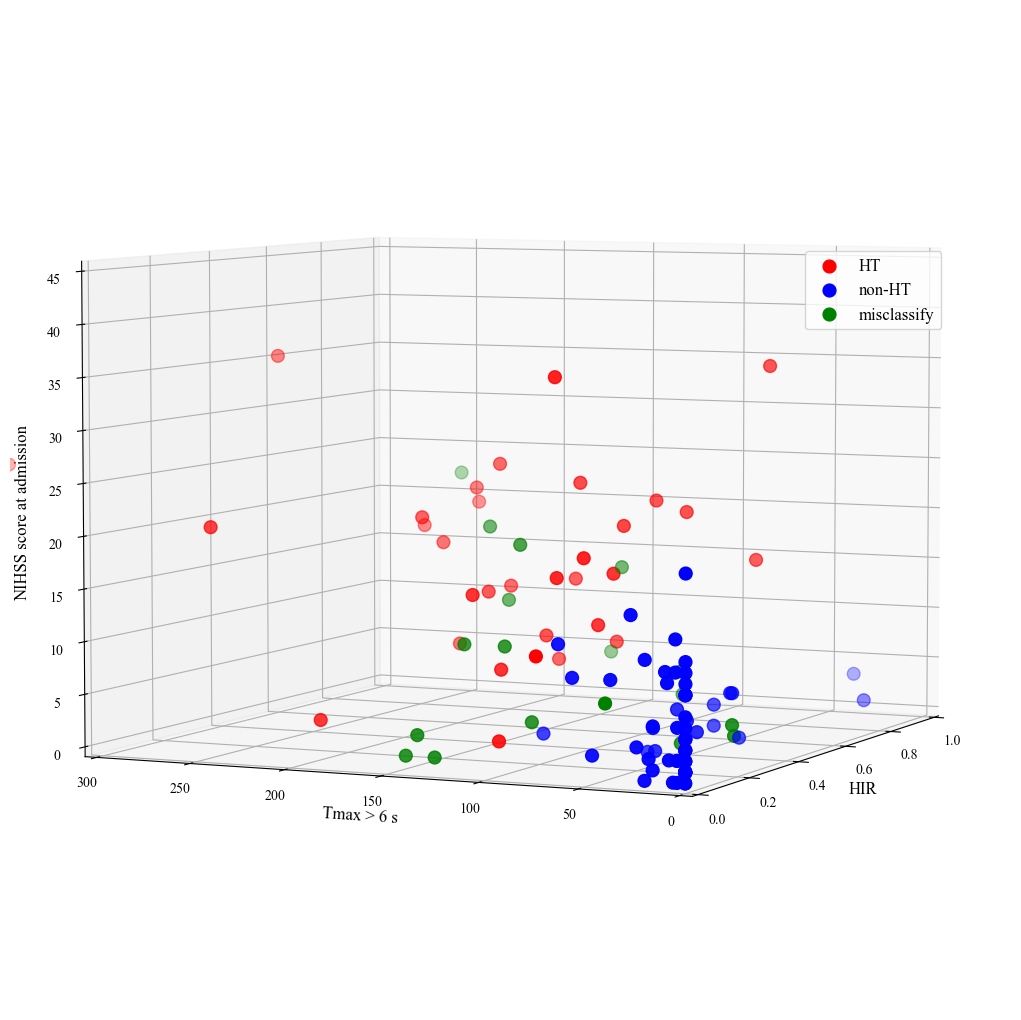

In [83]:
fl = ['Tmax > 6 s','HIR','NIHSS score at admission','Risk of HT']  
fig = plt.figure(figsize=(13,13))
plot_feature([1,0,2],fig,111)
plt.savefig('./figures/logistic_regression_visualization_version21.jpg',dpi=300,bbox_inches='tight',pad_inches=0.0)
plt.show()


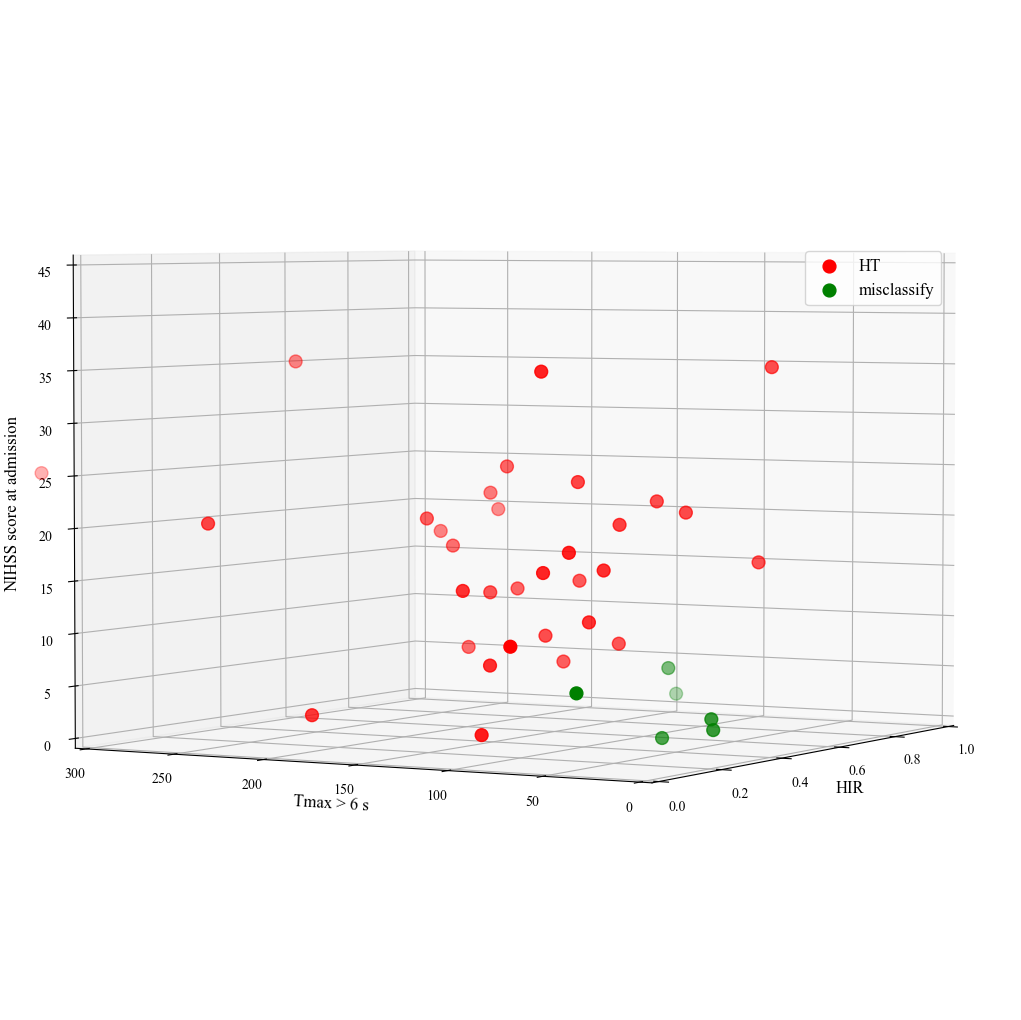

In [91]:
index = 1
def group2(feature_ls):
    y_pred = best_model_lr.predict(X_test_sc)
    ht_feature = feature_ls[y_test[(y_test == index ) & (y_test == y_pred)].index]  
    noht_feature = feature_ls[y_test[(y_test == index) & (y_test != y_pred)].index] #  
 
    return (ht_feature,noht_feature)

fl = ['Tmax > 6 s','HIR','NIHSS score at admission','Risk of HT'] 
ls_idx = [1,0,2]
ticks_seq = [fl[ls_idx[0]],fl[ls_idx[1]],fl[ls_idx[2]]]
x = X_test[ticks_seq[0]].loc[y_test[y_test==index].index]
x_val = group2(x)
y = X_test[ticks_seq[1]].loc[y_test[y_test==index].index]
y_val = group2(y)
z = X_test[ticks_seq[-1]].loc[y_test[y_test==index].index]
z_val = group2(z)

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_val[0], y_val[0], z_val[0], label='HT',s = 85,color="red") #risk_plot_val[0]*2)
ax.scatter(x_val[1], y_val[1], z_val[1], label = 'misclassify',s = 85,color = "green") #risk_plot_val[1]*2)
# plt.title('Risk of %s, %s and %s'%(ticks_seq[0],ticks_seq[1],ticks_seq[2]),fontsize=45)
        
# ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel('HIR',fontsize=12) #,fontsize=25) #,labelpad=20)
ax.set_ylabel('Tmax > 6 s',fontsize=12) #,fontsize=25) #,labelpad=20)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation 
ax.set_zlabel('NIHSS score at admission',fontsize=12,rotation=90) #,fontsize=25) #,labelpad=40,rotation=0)
f = lambda x,y,z: proj3d.proj_transform(x,y,z, ax.get_proj())[:2]
# if idx == 133:
plt.legend(bbox_to_anchor=(0.85,0.7), 
            bbox_transform=fig.transFigure,
            prop={'size': 12})
    
ax.set_xlim(1,0)
ax.set_ylim(300,0)
ax.set_zlim(0,45)
ax.view_init(3, 30)

plt.savefig('./figures/logistic_regression_visualization_version22.jpg',dpi=300,bbox_inches='tight',pad_inches=0.0)
plt.show()

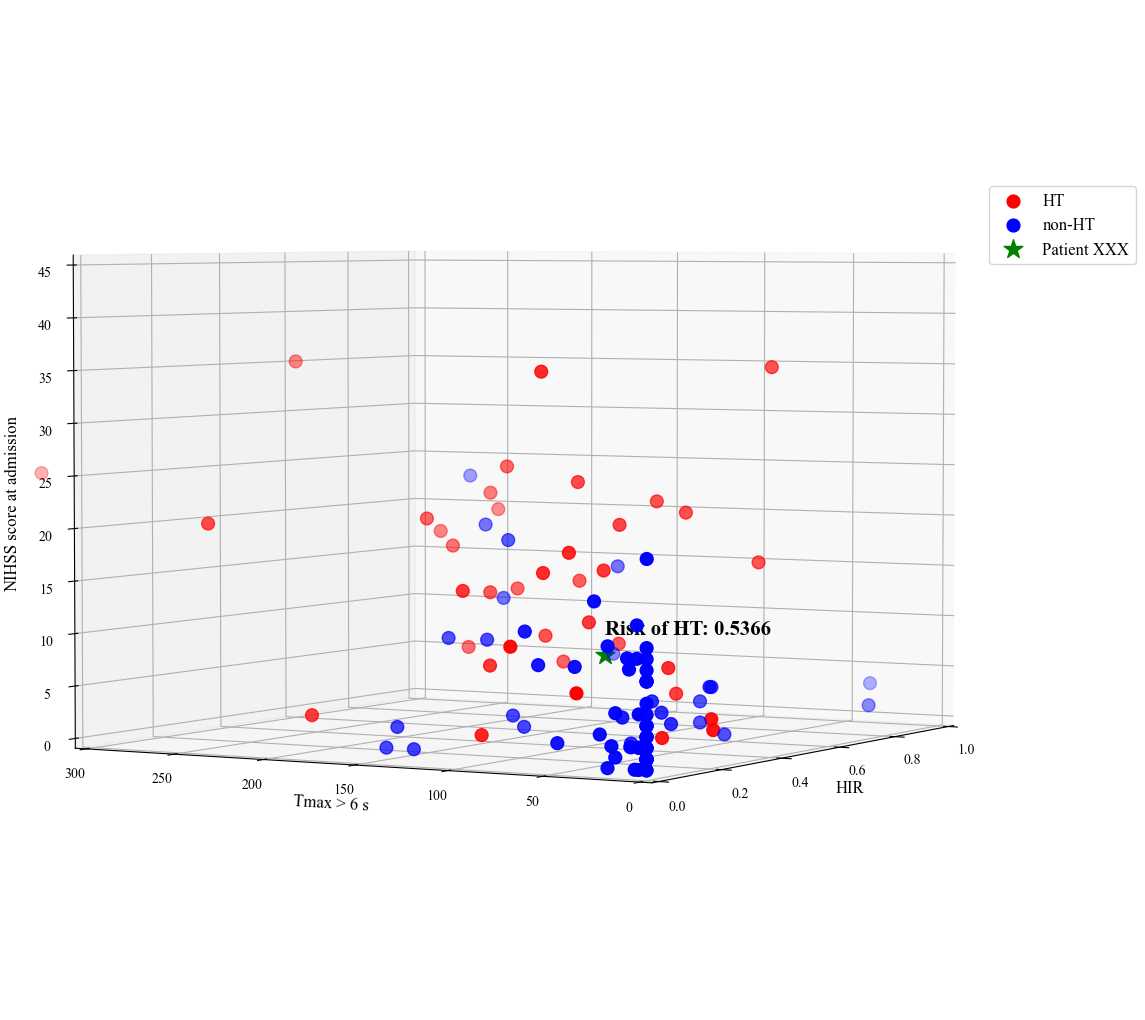

In [90]:

# def group2(feature_ls):
     
#     ht_feature = feature_ls[y_test[(y_test == 1 )].index]  
#     noht_feature = feature_ls[y_test[(y_test == 0) ].index] #  
 
#     return (ht_feature,noht_feature)

# fl = ['Tmax>6 Volume','VTmax>10s/VTmax>6s','NIHSS','Risk of HT'] 
# ls_idx = [1,0,2]
# ticks_seq = [fl[ls_idx[0]],fl[ls_idx[1]],fl[ls_idx[2]]]
# x = X_test[ticks_seq[0]]
# x_val = group2(x)
# y = X_test[ticks_seq[1]]
# y_val = group2(y)
# z = X_test[ticks_seq[-1]]
# z_val = group2(z)

# fig = plt.figure(figsize=(13,13))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(x_val[0], y_val[0], z_val[0], label='HT',s = 85,color="red") #risk_plot_val[0]*2)
# ax.scatter(x_val[1], y_val[1], z_val[1], label = 'non-HT',s = 85,color = "blue") #risk_plot_val[1]*2)

# ax.scatter([0.4],[88],[8],label='Patient XXX',s = 200,color = "green",marker = "*")
        
# # ax.tick_params(axis='both', which='major', labelsize=10)
# ax.set_xlabel('HIR',fontsize=12) #,fontsize=25) #,labelpad=20)
# ax.set_ylabel('Tmax > 6 s',fontsize=12) #,fontsize=25) #,labelpad=20)
# ax.zaxis.set_rotate_label(False)  # disable automatic rotation 
# ax.set_zlabel('NIHSS score at admission',fontsize=12,rotation=90) #,fontsize=25) #,labelpad=40,rotation=0)
# f = lambda x,y,z: proj3d.proj_transform(x,y,z, ax.get_proj())[:2]
# # if idx == 133:
# plt.legend(bbox_to_anchor=(1,0.75), 
#             bbox_transform=fig.transFigure,
#             prop={'size': 12})
    
# ax.set_xlim(1,0)
# ax.set_ylim(300,0)
# ax.set_zlim(0,45)
# ax.view_init(3, 30)

# ax.text(0.4, 88,10,"Risk of HT: 0.5366",fontsize=15,fontweight='bold')


# plt.savefig('./figures/example.jpg',dpi=300,bbox_inches='tight',pad_inches=0.0)
# plt.show()

### SVM 

In [17]:
best_model_svm,train_result_svm,test_result_svm,df_result_svm = main(X_train,X_train_sc,y_train,
                                                                     X_test,X_test_sc,y_test,
                                                                     model_name='SVM',
                                                                     scoring='f1')
df_result_svm

MODEL: SVM


,ACC,AUC,F1,SEN,SPC,PPV,NPV
TRAIN,0.8604,0.9468,0.7836,0.7283,0.9306,0.8481,0.8656
TEST,0.8333,0.8862,0.7595,0.7692,0.8667,0.7500,0.8784


PermutationExplainer explainer: 115it [00:23,  3.14it/s]                         


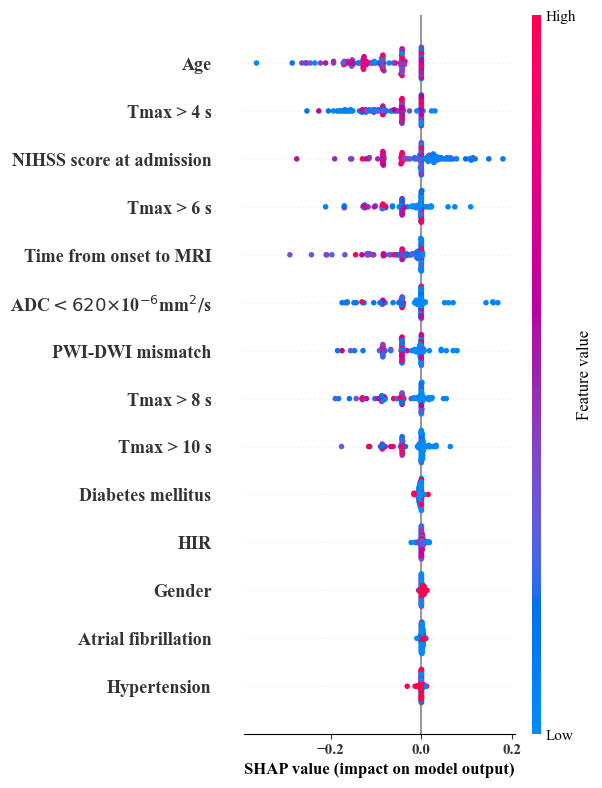

In [19]:
explainer = shap.Explainer(best_model_svm.predict, X_train_sc)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,show=False,plot_size=(6,8))


fig = plt.gcf()
ax = plt.gca()
ax.set_ylabel(ax.get_ylabel(), fontsize=12, fontweight='bold')
ax.set_xlabel(ax.get_xlabel(), fontsize=12, fontweight='bold')

 
for label in ax.get_yticklabels():
    label.set_fontweight('bold')


for label in ax.get_xticklabels():
    label.set_fontweight('bold')


plt.show()

### Decision TREE

In [23]:
best_model_dt,train_result_dt,test_result_dt,df_result_dt = main(X_train,X_train_sc,y_train,
                                                                 X_test,X_test_sc,y_test,
                                                                 model_name='DT',
                                                                 scoring='accuracy')
df_result_dt

MODEL: DT


,ACC,AUC,F1,SEN,SPC,PPV,NPV
TRAIN,0.8528,0.9193,0.8152,0.9348,0.8092,0.7227,0.9589
TEST,0.7632,0.8691,0.7216,0.8974,0.6933,0.6034,0.9286


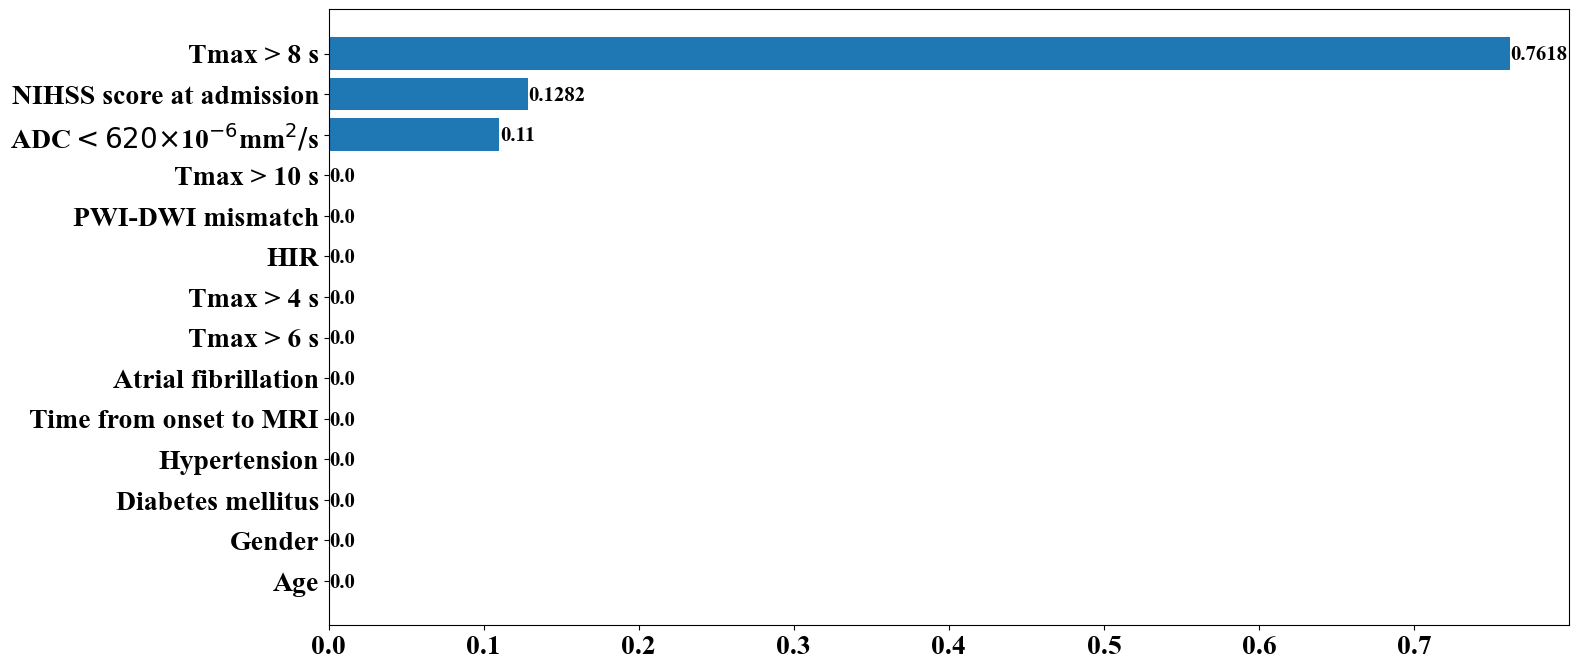

In [25]:
import_df = pd.DataFrame({'Feature':features,'Importance':best_model_dt.feature_importances_})
import_df = import_df.sort_values(ascending=True,by='Importance').round(4)
x = import_df['Feature'].tolist()
y = import_df['Importance']
plt.figure(figsize=(16,8))
plt.rcParams['font.family'] = ['Times New Roman']
plt.barh(x, y)
plt.yticks(fontsize=16)
plt.xticks(fontproperties = 'Times New Roman',fontsize=20,fontweight = "bold")
plt.yticks(fontproperties = 'Times New Roman',fontsize=20,fontweight = "bold")

for index, value in enumerate(y):
    plt.text(value+0.0003, index-0.15,round(value,4),fontsize=15,fontweight='bold')
plt.savefig('./figures/logistic_regression_feature_importance.jpg',dpi=300,bbox_inches='tight') #,pad_inches=0.0)

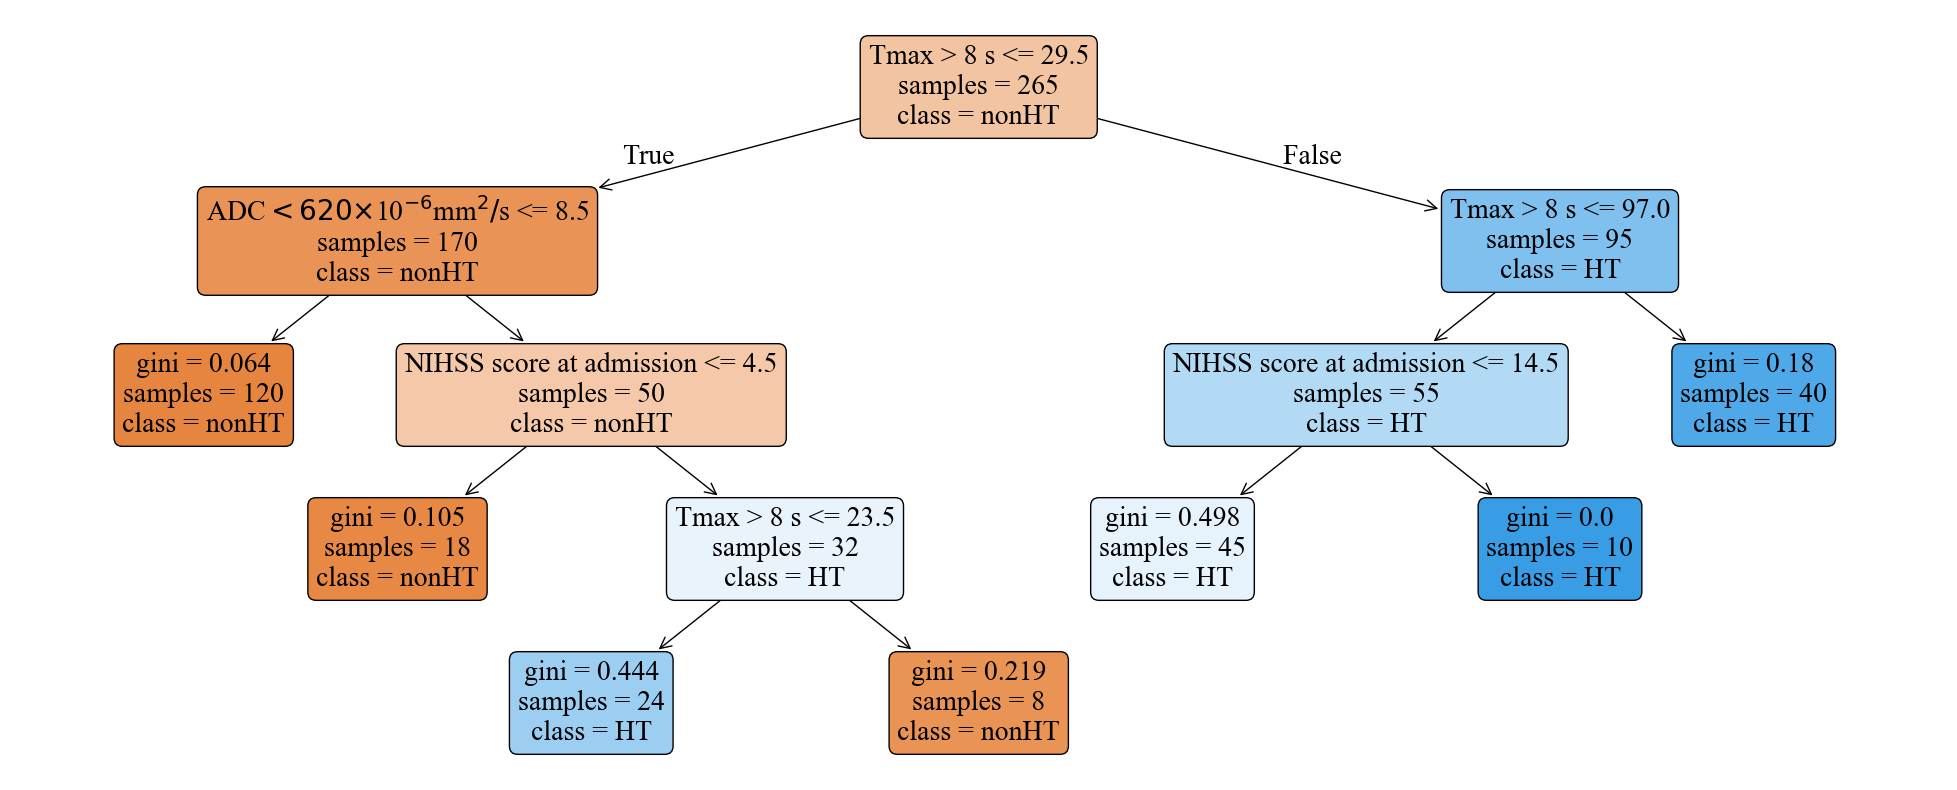

In [26]:
fig, ax = plt.subplots(figsize=(25,10))
tree.plot_tree(best_model_dt,
               ax = ax,
               feature_names=features,
               class_names = ['nonHT','HT'],
               rounded=True,
               fontsize=20,
               filled=True)

def replace_text(obj):
    if type(obj) == matplotlib.text.Annotation:
        txt = obj.get_text()
        txt = re.sub("\ngini[^$]*samples","\nsamples",txt)
        txt = re.sub("\nvalue[^$]*class","\nclass",txt)
        obj.set_text(txt)
    return obj
    
ax.properties()['children'] = [replace_text(i) for i in ax.properties()['children']]
plt.show()

### XGBoost

In [45]:
best_model_xgb,train_result_xgb,test_result_xgb,df_result_xgb = main(X_train,X_train_sc,y_train,
                                                                 X_test,X_test_sc,y_test,
                                                                 model_name='XGBoost',
                                                                 scoring='accuracy')
df_result_xgb

MODEL: XGBoost


,ACC,AUC,F1,SEN,SPC,PPV,NPV
TRAIN,0.9132,0.9728,0.8757,0.8804,0.9306,0.8710,0.9360
TEST,0.8684,0.9067,0.8148,0.8462,0.8800,0.7857,0.9167


Text(0.5, 1.0, 'XGBoost SHAP Summary Plot')

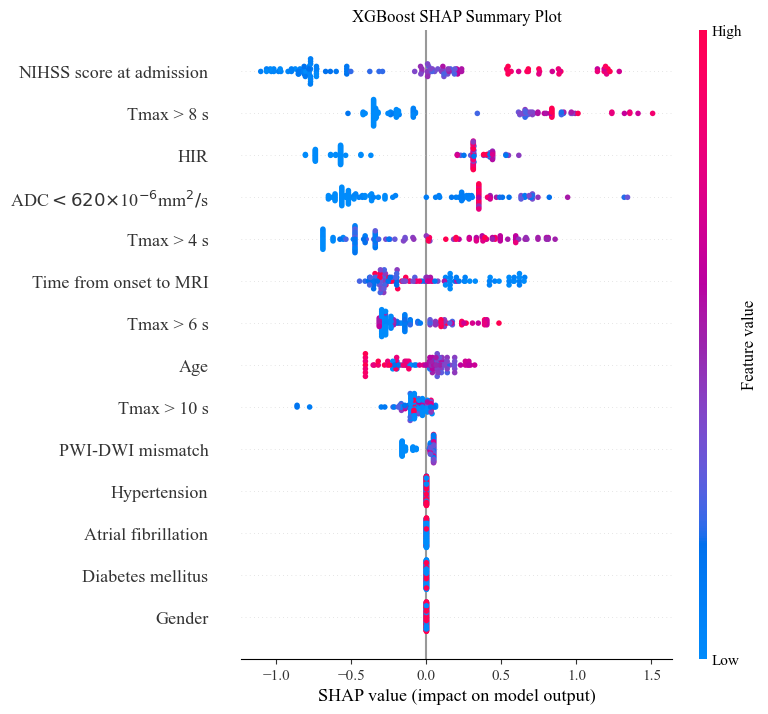

In [47]:
explainer = shap.TreeExplainer(best_model_xgb)
explanation = explainer(X_test_sc)
shap_values = explanation.values
shap.summary_plot(shap_values, X_test,show=False)
plt.title('XGBoost SHAP Summary Plot')

### Light GBM

In [48]:
best_model_gbm,train_result_gbm,test_result_gbm,df_result_gbm = main(X_train,X_train_sc,y_train,
                                                                 X_test,X_test_sc,y_test,
                                                                 model_name='LightGBM',
                                                                 scoring='roc_auc')
df_result_gbm

MODEL: LightGBM
[LightGBM] [Info] Number of positive: 92, number of negative: 173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347170 -> initscore=-0.631503
[LightGBM] [Info] Start training from score -0.631503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

,ACC,AUC,F1,SEN,SPC,PPV,NPV
TRAIN,0.9245,0.9759,0.8936,0.9130,0.9306,0.8750,0.9527
TEST,0.8860,0.9096,0.8434,0.8974,0.8800,0.7955,0.9429


Text(0.5, 1.0, 'LightGBM SHAP Summary Plot')

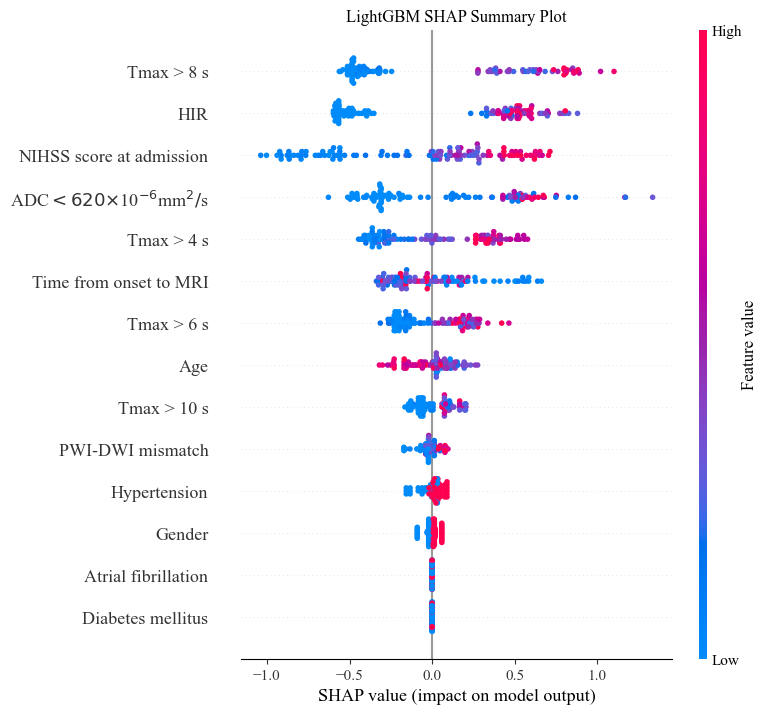

In [50]:
explainer = shap.TreeExplainer(best_model_gbm)
explanation = explainer(X_test_sc)
shap_values = explanation.values
shap.summary_plot(shap_values, X_test,show=False)
plt.title('LightGBM SHAP Summary Plot')

### Random Forest

In [62]:
best_model_rf,train_result_rf,test_result_rf,df_result_rf = main(X_train,X_train_sc,y_train,
                                                                 X_test,X_test_sc,y_test,
                                                                 model_name='RF',
                                                                 scoring='accuracy')
df_result_rf

MODEL: RF


,ACC,AUC,F1,SEN,SPC,PPV,NPV
TRAIN,0.8377,0.9166,0.7676,0.7717,0.8728,0.7634,0.8779
TEST,0.8421,0.9068,0.7907,0.8718,0.8267,0.7234,0.9254


Text(0.5, 1.0, 'Random Forest SHAP Summary Plot')

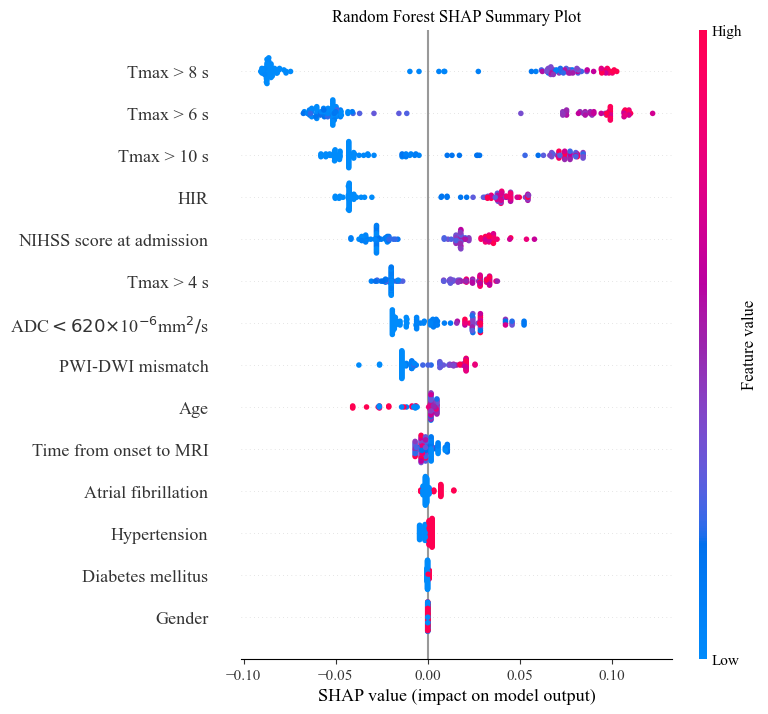

In [64]:
# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(best_model_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[:,:,1], X_test,show=False)
plt.title('Random Forest SHAP Summary Plot')

## Summary

In [36]:
import pickle 

models = {'scalar':scalar,
          'lr':best_model_lr,
          'svm':best_model_svm,
          'dt': best_model_dt,
          'xgb':best_model_xgb,
          'gbm':best_model_gbm,
          'rf':best_model_rf}
with open('./model.pkl','wb') as in_file:
    pickle.dump(models,in_file)

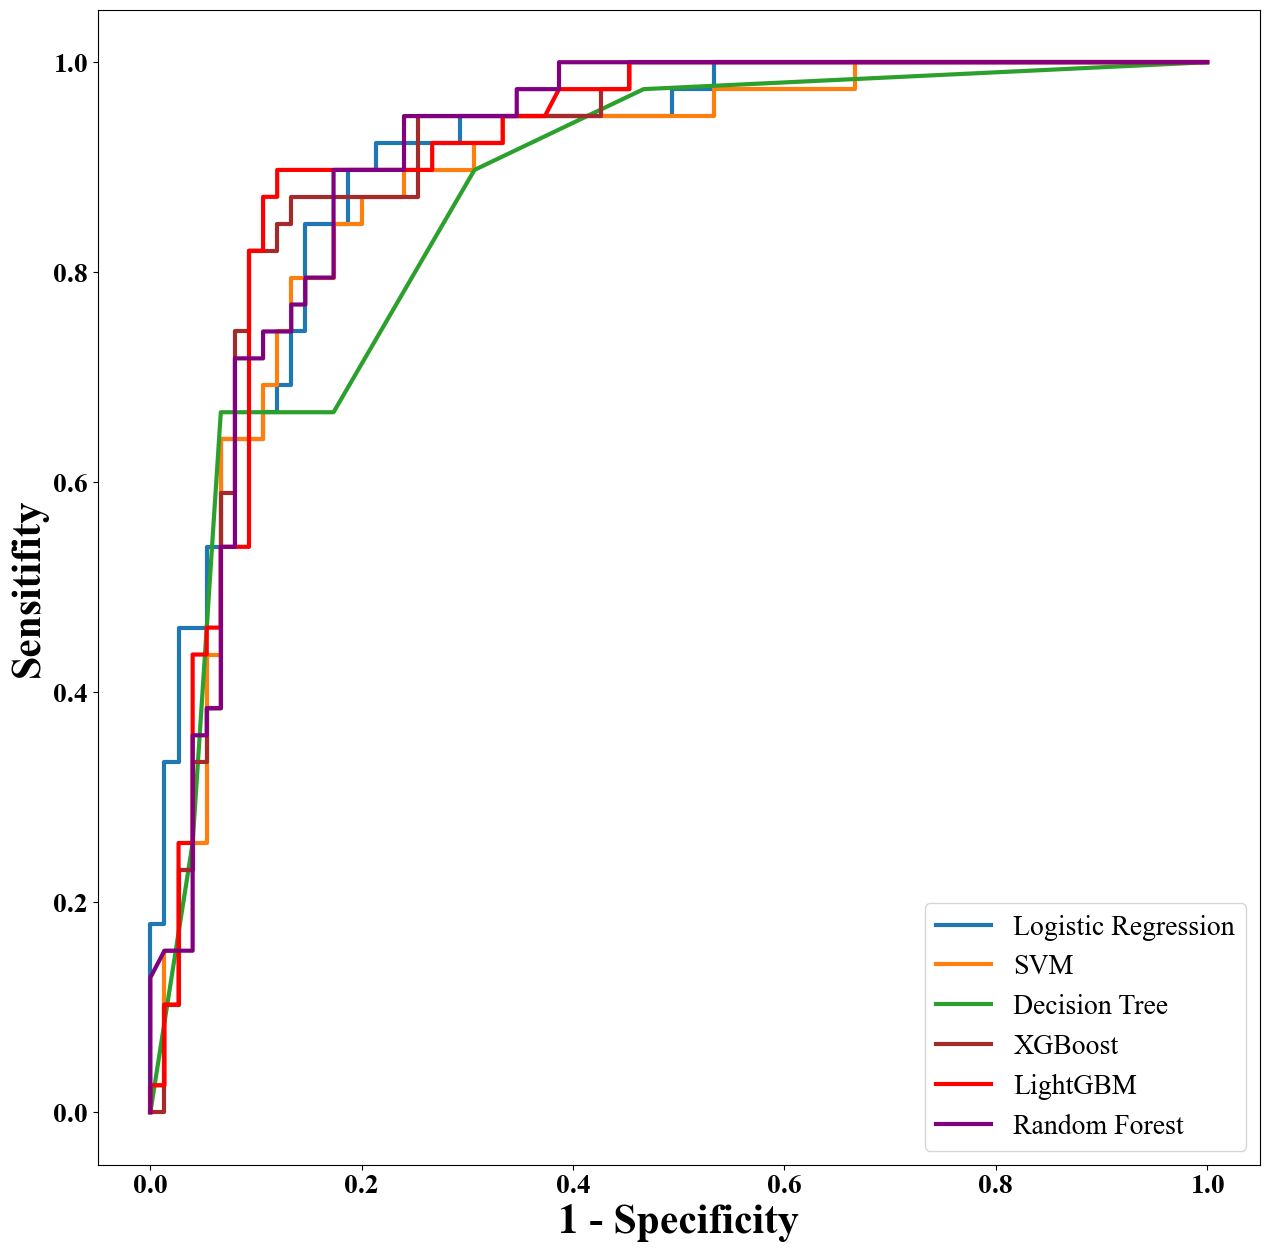

In [30]:
plt.figure(figsize=(15,15))

y_pred_proba_lr = best_model_lr.predict_proba(X_test_sc)[:,1]
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_proba_lr)
auc = metrics.roc_auc_score(y_test, y_pred_proba_lr)
plt.plot(fpr,tpr,label="Logistic Regression",linewidth=3) #, AUC = "+str(round(auc,4)),linewidth=3)

y_pred_proba_svm = 1/ (1+np.exp(-best_model_svm.decision_function(X_test_sc))) 
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_proba_svm)
auc = metrics.roc_auc_score(y_test, y_pred_proba_svm)
plt.plot(fpr,tpr,label="SVM",linewidth=3)#, AUC = "+str(round(auc,4)),linewidth=3)

y_pred_proba_dt = best_model_dt.predict_proba(X_test)[:,1]
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_proba_dt)
auc = metrics.roc_auc_score(y_test, y_pred_proba_dt)
plt.plot(fpr,tpr,label="Decision Tree",linewidth=3)#, AUC = "+str(round(auc,4)),linewidth=3)

y_pred_proba_xgb = best_model_xgb.predict_proba(X_test_sc)[:, 1]  
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_proba_xgb)
auc = metrics.roc_auc_score(y_test, y_pred_proba_xgb)
plt.plot(fpr,tpr,label="XGBoost",linewidth=3,color='brown')#, AUC = "+str(round(auc,4)),linewidth=3)


y_pred_proba_gbm = best_model_gbm.predict_proba(X_test_sc)[:, 1]  
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_proba_gbm)
auc = metrics.roc_auc_score(y_test, y_pred_proba_gbm)
plt.plot(fpr,tpr,label="LightGBM",linewidth=3,color='red')#, AUC = "+str(round(auc,4)),linewidth=3)


y_pred_proba_rf = best_model_rf.predict_proba(X_test)[:, 1]  
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_proba_rf)
auc = metrics.roc_auc_score(y_test, y_pred_proba_rf)
plt.plot(fpr,tpr,label="Random Forest",linewidth=3,color='purple')#, AUC = "+str(round(auc,4)),linewidth=3)



plt.xticks(fontproperties = 'Times New Roman',fontsize=15)
plt.yticks(fontproperties = 'Times New Roman',fontsize=15)

plt.xlabel('1 - Specificity',fontsize=30,fontproperties = 'Times New Roman',fontweight = "bold")
plt.ylabel('Sensitifity',fontsize=30,fontproperties = 'Times New Roman',fontweight = "bold")
plt.legend(loc=4,prop={'size': 20,'family' : 'Times New Roman'})

plt.xticks(fontproperties = 'Times New Roman',fontsize=20,fontweight = "bold")
plt.yticks(fontproperties = 'Times New Roman',fontsize=20,fontweight = "bold")


plt.savefig('figures/roc_auc_six.jpg',dpi=300)